---
Взял этот датасет по возрасту https://archive.ics.uci.edu/ml/datasets/Adult

#### Описание

```
| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Duplicate or conflicting instances : 6
|
| Extraction was done by Barry Becker from the 1994 Census database.
|
| Prediction task is to determine whether a person makes over 50K
| a year.
|| Conversion of original data as follows:
| 1. Discretized agrossincome into two ranges with threshold 50,000.
| 2. Convert U.S. to US to avoid periods.
| 3. Convert Unknown to "?"
| 4. Run MLC++ GenCVFiles to generate data,test.
|
| Description of fnlwgt (final weight)
|
| The weights on the CPS files are controlled to independent estimates of the
| civilian noninstitutional population of the US.  These are prepared monthly
| for us by Population Division here at the Census Bureau.  We use 3 sets of
| controls.
|  These are:
|          1.  A single cell estimate of the population 16+ for each state.
|          2.  Controls for Hispanic Origin by age and sex.
|          3.  Controls by Race, age and sex.
|
| We use all three sets of controls in our weighting program and "rake" through
| them 6 times so that by the end we come back to all the controls we used.
|
| The term estimate refers to population totals derived from CPS by creating
| "weighted tallies" of any specified socio-economic characteristics of the
| population.
|
| People with similar demographic characteristics should have
| similar weights.  There is one important caveat to remember
| about this statement.  That is that since the CPS sample is
| actually a collection of 51 state samples, each with its own
| probability of selection, the statement only applies within
| state.
```

- income: >50K, <=50K.
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from my_pipeline_selectors import FeatureSelector, OHEEncoder, NumberSelector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
target = 'income'

df = pd.read_csv('data/adult.data', sep=',', index_col=False, names=features + [target])
df_test = pd.read_csv('data/adult.test', sep=',', index_col=False, names=features + [target])

## обзорный анализ выбранного датасета

In [3]:
display(df.head(3), df.shape)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


(32561, 15)

In [4]:
display(df_test.head(10), df_test.shape)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.
7,29,?,227026.0,HS-grad,9.0,Never-married,?,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K.
8,63,Self-emp-not-inc,104626.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K.
9,24,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K.


(16282, 15)

In [5]:
# Проврка пропусков
pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Проверка дубликатов
df.duplicated(keep=False).value_counts()

False    32514
True        47
dtype: int64

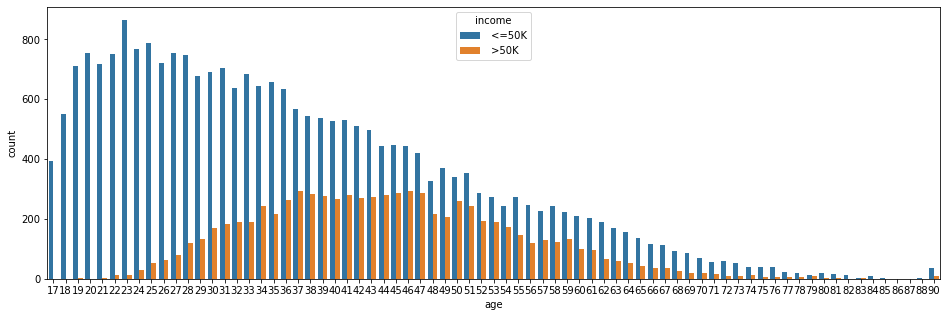

In [7]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age', hue='income');

## feature engineering

In [8]:
# Изменение целевой переменной
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
df_test['income'] = df_test['income'].map({' <=50K': 0, ' >50K': 1})

In [9]:
# categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country' ]
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',]

# continuous_columns = ['fnlwgt', 'age', 'education-num', 'capital-gain','capital-loss', 'hours-per-week',]
continuous_columns = ['age', 'education-num', 'capital-gain','capital-loss', 'hours-per-week',]
final_transformers = list()

scaler = StandardScaler()
scaler.fit(df[continuous_columns])

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standardizer', scaler)
    ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [11]:
%%time
from xgboost import XGBClassifier

xgboost_pipeline = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(objective="binary:logistic", use_label_encoder=False, random_state=42)),
])

CPU times: user 115 ms, sys: 11.8 ms, total: 126 ms
Wall time: 125 ms


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

X = df.drop(columns=['income', 'fnlwgt', 'native-country', 'race', 'sex'])
y = df['income']

xgboost_precision_scores = cross_val_score(xgboost_pipeline, X, y, cv=cv, scoring="precision_macro").mean()
xgboost_recall_scores = cross_val_score(xgboost_pipeline, X, y, cv=cv, scoring="recall_macro").mean()
xgboost_roc_auc_scores = cross_val_score(xgboost_pipeline, X, y, cv=cv, scoring="roc_auc").mean()
xgboost_f1_score_scores = cross_val_score(xgboost_pipeline, X, y, cv=cv, scoring="f1_macro").mean()

[21:04:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [13]:
data = {
    'xgboost': [
        np.mean(xgboost_precision_scores),
        np.mean(xgboost_recall_scores),
        np.mean(xgboost_roc_auc_scores),
        np.mean(xgboost_f1_score_scores)
    ]
}
before = pd.DataFrame.from_dict(data, orient='index', columns=['precision', 'recall', 'roc_auc', 'f1_score'])
before

,precision,recall,roc_auc,f1_score
xgboost,0.831633,0.796176,0.92477,0.811398


In [14]:
xgboost_pipeline.steps

[('features',
  FeatureUnion(transformer_list=[('workclass',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='workclass')),
                                                  ('ohe',
                                                   OHEEncoder(key='workclass'))])),
                                 ('education',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='education')),
                                                  ('ohe',
                                                   OHEEncoder(key='education'))])),
                                 ('marital-status',
                                  Pipeline(steps=[('selector',
                                                   FeatureSelector(column='marital-status'...
                                 ('capital-gain',
                                  Pipeline(st

In [16]:
import dill

X = df.drop(columns=['income', 'fnlwgt', 'native-country', 'race', 'sex'])
y = df['income']

xgboost_pipeline.fit(X, y)



with open("../app/models/xgboost_pipeline.dill", "wb") as f:
    dill.dump(xgboost_pipeline, f)

[21:06:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
